In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils
from IPython.display import clear_output

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

public_kwh = APT - month_df['usage (kWh)'].sum()
public_kwh

13330

In [10]:
from src import SavingFeedback

# 1. Data Pre-processing
ksf = SavingFeedback(xlsx)
ksf.select_month(1)

# 2. KMeans Run
ksf.kmeans_run()

# 3. adjust anomaly
ksf.adjust_anomaly()
anomaly = ksf.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

time_size = 3

ksf.time_based_grouping(time_size)
ksf.feedback()
ksf.result()

kmeans_time_group = ksf.new_group.copy()
kmeans_time_group.head()

ECV : 51 %
이상패턴 조정 확인 True


,name,usage (kWh),label
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0


In [30]:
round(kmeans_time_group['usage (kWh)'].mean())

231

In [13]:
tsf = SavingFeedback(xlsx, _type="tdkmeans")

tsf.select_month(1)
tsf.kmeans_run()

tsf.adjust_anomaly()
anomaly = tsf.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

time_size = 3

tsf.time_based_grouping(time_size)
tsf.feedback()
tsf.result()

tdkmeans_time_group = tsf.new_group.copy()


clear_output(wait=True)
tdkmeans_time_group.head()

,name,usage (kWh),label
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0


In [16]:
round(tdkmeans_time_group['usage (kWh)'].mean())

241

In [32]:
kmeans_APT = round(kmeans_time_group['usage (kWh)'].sum()) + public_kwh
tdkmeans_APT = round(tdkmeans_time_group['usage (kWh)'].sum()) + public_kwh

print(kmeans_APT, tdkmeans_APT)

38296 39307


In [36]:
kmeans_calc = crs.models.ManagementOffice(
    month=_month,
    households=kmeans_time_group.copy(),
    APT=kmeans_APT,
    contract='단일계약'
)
tdkmeans_calc = crs.models.ManagementOffice(
    month=_month,
    households=tdkmeans_time_group.copy(),
    APT=tdkmeans_APT,
    contract='단일계약'
)

In [45]:
# APT 평균 사용량
print(calc.apart.kwh, kmeans_calc.apart.kwh, tdkmeans_calc.apart.kwh)

# 세대부 평균 사용량
print(round(month_df['usage (kWh)'].mean()),
     round(kmeans_time_group['usage (kWh)'].mean()),
     round(tdkmeans_time_group['usage (kWh)'].mean()))


# 아파트 전체요금
print(calc.bill, kmeans_calc.bill, tdkmeans_calc.bill)

# 세대부 전체요금
print(calc.bill - calc.public_bill,
     kmeans_calc.bill - kmeans_calc.public_bill,
     tdkmeans_calc.bill - tdkmeans_calc.public_bill)

# 공용부 요금
print(calc.public_bill,
     kmeans_calc.public_bill,
     tdkmeans_calc.public_bill)

411 355 364
288 231 241
6439540 4763500 4923370
3798980 2637760 2871750
2640560 2125740 2051620


In [46]:
def get_col_list(kWh, fee):
    col_list = list()
    _usage = kWh
    for step, _f in enumerate(fee):
        collect_rate = _f[1] - _f[0]

        # 2단계일 경우
        if step == 1:
            collect_rate += 1

        if kWh < _f[1]:
            if (step == 0) or (step == 1):
                _col = _usage % collect_rate
            else:
                _col = _usage
        else:
            _col = collect_rate

        if _usage == 0:
            col_list.append(0)
        else:
            col_list.append(_col)
            _usage -= _col

    return np.array(col_list)

def get_step_mem(col_list, fee):
    _mem = list()
    _mem_step = 0
    
    for step,val in enumerate(col_list):
        _val = val
        f = fee[step][3]
        
        while _val != 0:
            _mem_step += f
            _mem.append(_mem_step)
            _val -= 1
            
            
    return np.array(_mem)

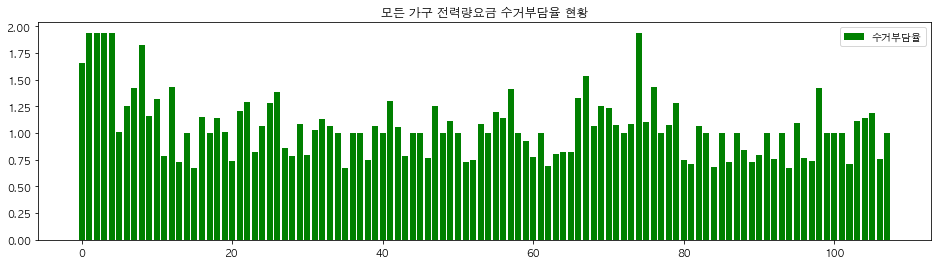

In [47]:
households_col = get_col_list(round(kmeans_time_group['usage (kWh)'].mean()), calc.fee)
APT_col = get_col_list(round(kmeans_APT / 108), calc.fee)
public_col = APT_col - households_col
public_mem = get_step_mem(public_col, calc.fee)

col_burden_list = list()

for usage in kmeans_time_group['usage (kWh)']:
    chk_households_col = get_col_list(usage, calc.fee)
    _APT_mean = usage + public_col.sum()

    chk_APT_col = get_col_list(_APT_mean, calc.fee)
    chk_public_col = chk_APT_col - chk_households_col
    chk_public_mem = get_step_mem(chk_public_col, calc.fee)
    col_burden = public_mem / chk_public_mem
    
    col_burden_list.append(col_burden[-1])
    
plt.figure(figsize=(16,4))

plt.bar(range(len(col_burden_list)), col_burden_list, color='g', label='수거부담율')
plt.yticks(np.arange(0, 2.1, 0.25))
plt.title("모든 가구 전력량요금 수거부담율 현황")

plt.legend()

plt.show()

In [48]:
np.array(col_burden_list).std()

0.2976727759409283

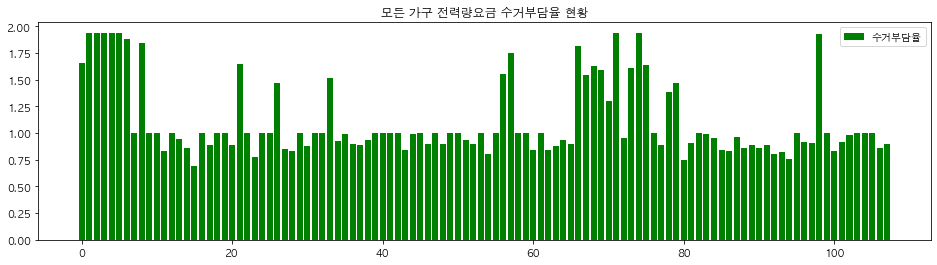

In [49]:
households_col = get_col_list(round(tdkmeans_time_group['usage (kWh)'].mean()), calc.fee)
APT_col = get_col_list(round(tdkmeans_APT / 108), calc.fee)
public_col = APT_col - households_col
public_mem = get_step_mem(public_col, calc.fee)

col_burden_list = list()

for usage in tdkmeans_time_group['usage (kWh)']:
    chk_households_col = get_col_list(usage, calc.fee)
    _APT_mean = usage + public_col.sum()

    chk_APT_col = get_col_list(_APT_mean, calc.fee)
    chk_public_col = chk_APT_col - chk_households_col
    chk_public_mem = get_step_mem(chk_public_col, calc.fee)
    col_burden = public_mem / chk_public_mem
    
    col_burden_list.append(col_burden[-1])
    
plt.figure(figsize=(16,4))

plt.bar(range(len(col_burden_list)), col_burden_list, color='g', label='수거부담율')
plt.yticks(np.arange(0, 2.1, 0.25))
plt.title("모든 가구 전력량요금 수거부담율 현황")

plt.legend()

plt.show()

In [50]:
np.array(col_burden_list).std()

0.35121732702879543

### 의미없는 피드백 확인

In [105]:
def get_min_err(sf):
    sf.recovery()
    og_pat = sf.datas.values.T
    rec_pat = sf.recoveries
    err = (og_pat - rec_pat)
    
    return err[err != 0].min()

In [106]:
kmeans_min = list()
tdkmeans_min = list()

In [111]:
import random as ran

while len(kmeans_min) < 100:
    try:
        random_n = ran.randrange(60, 100)

        date_info = xlsx[xlsx.columns[:7]]
        hh_info = xlsx[xlsx.columns[7:]].sample(n=random_n, axis=1)

        _xlsx = pd.concat([date_info, hh_info], axis=1)

        # 1. Data Pre-processing
        _ksf = SavingFeedback(_xlsx)
        _ksf.select_month(1)

        # 2. KMeans Run
        _ksf.kmeans_run()

        # 3. adjust anomaly
        _ksf.adjust_anomaly()
        anomaly = _ksf.check_anomaly()
        print("이상패턴 조정 확인", len(anomaly) == 0)

        time_size = 3

        _ksf.time_based_grouping(time_size)
        _ksf.feedback()
        _ksf.result()

        _kmeans_time_group = _ksf.new_group.copy()
        _kmeans_time_group.head()

        _tsf = SavingFeedback(_xlsx, _type="tdkmeans")

        _tsf.select_month(1)
        _tsf.kmeans_run()

        _tsf.adjust_anomaly()
        anomaly = _tsf.check_anomaly()
        print("이상패턴 조정 확인", len(anomaly) == 0)

        time_size = 3

        _tsf.time_based_grouping(time_size)
        _tsf.feedback()
        _tsf.result()

        _tdkmeans_time_group = _tsf.new_group.copy()

        clear_output(wait=True)
        _tdkmeans_time_group.head()

        kmeans_min.append(get_min_err(_ksf))
        tdkmeans_min.append(get_min_err(_tsf))
    except:
        continue

ECV : 49 %
이상패턴 조정 확인 True
1/248 - ECV:86%
11/248 - ECV:76%
21/248 - ECV:86%
31/248 - ECV:87%
41/248 - ECV:86%
51/248 - ECV:83%
61/248 - ECV:89%
71/248 - ECV:82%
81/248 - ECV:88%
91/248 - ECV:79%
101/248 - ECV:85%
111/248 - ECV:82%
121/248 - ECV:83%
131/248 - ECV:78%
141/248 - ECV:86%
151/248 - ECV:88%
161/248 - ECV:88%
171/248 - ECV:78%
181/248 - ECV:81%
191/248 - ECV:83%
201/248 - ECV:86%
211/248 - ECV:79%
221/248 - ECV:85%
231/248 - ECV:82%
241/248 - ECV:87%
248/248 - ECV:86%
[tdkmeans] adjust anomaly :)
1/248 - ECV:82%
11/248 - ECV:66%
21/248 - ECV:81%
31/248 - ECV:87%
41/248 - ECV:84%
51/248 - ECV:79%
61/248 - ECV:87%
71/248 - ECV:81%
81/248 - ECV:88%
91/248 - ECV:67%
101/248 - ECV:81%
111/248 - ECV:77%
121/248 - ECV:76%
131/248 - ECV:60%
141/248 - ECV:79%
151/248 - ECV:83%
161/248 - ECV:85%
171/248 - ECV:71%
181/248 - ECV:74%
191/248 - ECV:79%
201/248 - ECV:84%
211/248 - ECV:63%
221/248 - ECV:80%
231/248 - ECV:75%
241/248 - ECV:85%
248/248 - ECV:86%
이상패턴 조정 확인 True


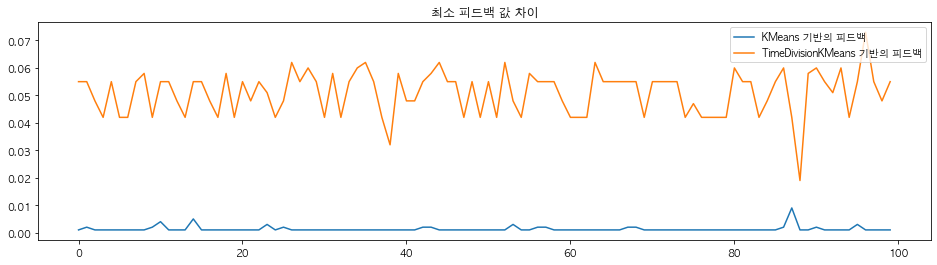

In [120]:
plt.figure(figsize=(16,4))

plt.title("최소 피드백 값 차이")

plt.plot(kmeans_min, label="KMeans 기반의 피드백")
plt.plot(tdkmeans_min, label="TimeDivisionKMeans 기반의 피드백")

plt.legend(loc='upper right')

plt.show()

In [121]:
print(np.array(kmeans_min).min())
print(np.array(kmeans_min).max())
print(np.array(kmeans_min).mean())

0.0009999999999998899
0.008999999999999897
0.0013199999999999434


In [122]:
print(np.array(tdkmeans_min).min())
print(np.array(tdkmeans_min).max())
print(np.array(tdkmeans_min).mean())

0.019
0.073
0.05101000000000001
